In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [2]:
from torchvision.transforms import Compose, ToTensor
from torchsummary import summary
import pickle
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import accuracy_metrics

from torch.nn import CrossEntropyLoss
from torch.optim import SGD

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom Libraries

In [4]:
import sys

sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.training.acewc_v1 import ACEWC

# Dataset and definitions

## Preprocessing definitions

In [5]:
train_transform = Compose(
    [
        ToTensor(),
    ]
)

test_transform = Compose(
    [
        ToTensor(),
    ]
)

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [6]:
# mnist_train = MNIST(DATASETS_PATH, train=True, download=True, transform=train_transform)
# mnist_test = MNIST(DATASETS_PATH, train=False, download=True, transform=test_transform)

scenario = PermutedMNIST(10, seed=1234, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [7]:
# scenario = nc_benchmark(
#     mnist_train, mnist_test,
#     n_experiences=len(mnist_train.classes), shuffle=True, seed=1234, task_labels=False
# )

train_stream = scenario.train_stream
test_stream = scenario.test_stream

## Evaluation metrics definition

In [8]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True), loggers=[InteractiveLogger()]
)

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [9]:
# model = MLP(n_classes=scenario.n_classes, n_channels=1, width=28, height=28)
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28 * 28, hidden_layers=2, hidden_size=100)
optimizer = SGD(model.parameters(), lr=1e-3)
criterion = CrossEntropyLoss()
strategy = ACEWC(
    model,
    optimizer,
    criterion,
    ewc_lambda=1.0,
    train_epochs=5,
    train_mb_size=128,
    evaluator=eval_plugin,
    eval_mb_size=128,
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

In [10]:
results = list()

for experience in tqdm(train_stream):
    strategy.train(experience)
    metrics = strategy.eval(test_stream)
    results.append(metrics)

  0%|          | 0/10 [00:00<?, ?it/s]

-- >> Start of training phase << --
100%|██████████| 469/469 [00:03<00:00, 128.65it/s]
Epoch 0 ended.
100%|██████████| 469/469 [00:03<00:00, 130.52it/s]
Epoch 1 ended.
100%|██████████| 469/469 [00:03<00:00, 129.96it/s]
Epoch 2 ended.
100%|██████████| 469/469 [00:03<00:00, 130.70it/s]
Epoch 3 ended.
100%|██████████| 469/469 [00:03<00:00, 130.02it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 147.22it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7481
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 146.92it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.2030
-- Starting eval on experience 2 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 138.04it/s]
>

 10%|█         | 1/10 [00:26<03:57, 26.43s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.2025
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.2355
-- >> Start of training phase << --
100%|██████████| 469/469 [00:04<00:00, 117.17it/s]
Epoch 0 ended.
100%|██████████| 469/469 [00:04<00:00, 117.12it/s]
Epoch 1 ended.
100%|██████████| 469/469 [00:03<00:00, 117.59it/s]
Epoch 2 ended.
100%|██████████| 469/469 [00:04<00:00, 117.10it/s]
Epoch 3 ended.
100%|██████████| 469/469 [00:04<00:00, 114.82it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 146.34it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.7010
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 147.23it/s]
> Eval on experience 1 (

 20%|██        | 2/10 [00:54<03:40, 27.60s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.2580
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.2979
-- >> Start of training phase << --
100%|██████████| 469/469 [00:04<00:00, 107.48it/s]
Epoch 0 ended.
100%|██████████| 469/469 [00:04<00:00, 107.02it/s]
Epoch 1 ended.
100%|██████████| 469/469 [00:04<00:00, 106.98it/s]
Epoch 2 ended.
100%|██████████| 469/469 [00:04<00:00, 105.60it/s]
Epoch 3 ended.
100%|██████████| 469/469 [00:04<00:00, 106.69it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 146.37it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6845
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 146.29it/s]
> Eval on experience 1 (

 30%|███       | 3/10 [01:25<03:21, 28.82s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1918
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.3430
-- >> Start of training phase << --
100%|██████████| 469/469 [00:04<00:00, 98.42it/s]
Epoch 0 ended.
100%|██████████| 469/469 [00:04<00:00, 97.90it/s] 
Epoch 1 ended.
100%|██████████| 469/469 [00:04<00:00, 97.84it/s]
Epoch 2 ended.
100%|██████████| 469/469 [00:04<00:00, 98.63it/s]
Epoch 3 ended.
100%|██████████| 469/469 [00:04<00:00, 97.50it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 147.36it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5899
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 148.15it/s]
> Eval on experience 1 (Task

 40%|████      | 4/10 [01:57<03:00, 30.16s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1393
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.3830
-- >> Start of training phase << --
100%|██████████| 469/469 [00:05<00:00, 89.23it/s]
Epoch 0 ended.
100%|██████████| 469/469 [00:05<00:00, 86.98it/s]
Epoch 1 ended.
100%|██████████| 469/469 [00:05<00:00, 90.00it/s]
Epoch 2 ended.
100%|██████████| 469/469 [00:05<00:00, 91.96it/s]
Epoch 3 ended.
100%|██████████| 469/469 [00:05<00:00, 92.61it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 152.65it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.6016
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 152.08it/s]
> Eval on experience 1 (Task 

 50%|█████     | 5/10 [02:31<02:37, 31.60s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1673
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4449
-- >> Start of training phase << --
100%|██████████| 469/469 [00:05<00:00, 87.26it/s]
Epoch 0 ended.
100%|██████████| 469/469 [00:05<00:00, 82.03it/s]
Epoch 1 ended.
100%|██████████| 469/469 [00:05<00:00, 82.13it/s]
Epoch 2 ended.
100%|██████████| 469/469 [00:05<00:00, 82.26it/s]
Epoch 3 ended.
100%|██████████| 469/469 [00:05<00:00, 82.59it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 141.22it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5496
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 145.07it/s]
> Eval on experience 1 (Task 

 60%|██████    | 6/10 [03:08<02:13, 33.29s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1439
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.5019
-- >> Start of training phase << --
100%|██████████| 469/469 [00:06<00:00, 77.83it/s]
Epoch 0 ended.
100%|██████████| 469/469 [00:06<00:00, 77.26it/s]
Epoch 1 ended.
100%|██████████| 469/469 [00:06<00:00, 78.13it/s]
Epoch 2 ended.
100%|██████████| 469/469 [00:05<00:00, 78.21it/s]
Epoch 3 ended.
100%|██████████| 469/469 [00:06<00:00, 77.81it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 147.39it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5543
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 135.71it/s]
> Eval on experience 1 (Task 

 70%|███████   | 7/10 [03:46<01:45, 35.00s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1314
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.5556
-- >> Start of training phase << --
100%|██████████| 469/469 [00:06<00:00, 73.54it/s]
Epoch 0 ended.
100%|██████████| 469/469 [00:06<00:00, 73.87it/s]
Epoch 1 ended.
100%|██████████| 469/469 [00:06<00:00, 73.77it/s]
Epoch 2 ended.
100%|██████████| 469/469 [00:06<00:00, 73.03it/s]
Epoch 3 ended.
100%|██████████| 469/469 [00:06<00:00, 73.21it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 147.84it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5065
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 150.63it/s]
> Eval on experience 1 (Task 

 80%|████████  | 8/10 [04:26<01:13, 36.65s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1317
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.6095
-- >> Start of training phase << --
100%|██████████| 469/469 [00:07<00:00, 66.21it/s]
Epoch 0 ended.
100%|██████████| 469/469 [00:06<00:00, 68.26it/s]
Epoch 1 ended.
100%|██████████| 469/469 [00:06<00:00, 68.37it/s]
Epoch 2 ended.
100%|██████████| 469/469 [00:06<00:00, 67.37it/s]
Epoch 3 ended.
100%|██████████| 469/469 [00:06<00:00, 68.20it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 145.85it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5043
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 138.77it/s]
> Eval on experience 1 (Task 

 90%|█████████ | 9/10 [05:09<00:38, 38.70s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.1614
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.6667
-- >> Start of training phase << --
100%|██████████| 469/469 [00:07<00:00, 65.87it/s]
Epoch 0 ended.
100%|██████████| 469/469 [00:07<00:00, 66.70it/s]
Epoch 1 ended.
100%|██████████| 469/469 [00:07<00:00, 66.34it/s]
Epoch 2 ended.
100%|██████████| 469/469 [00:07<00:00, 65.15it/s]
Epoch 3 ended.
100%|██████████| 469/469 [00:07<00:00, 62.62it/s]
Epoch 4 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 146.65it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.4925
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 150.25it/s]
> Eval on experience 1 (Task 

100%|██████████| 10/10 [05:54<00:00, 35.42s/it]


> Eval on experience 9 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp009 = 0.8441
-- >> End of eval phase << --
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.7237


In [11]:
accuracies: dict[int, list[float]] = dict()

for i in range(10):
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00{i}"
    ][1][-10:]

accuracies["Overall"] = eval_plugin.get_all_metrics()[
    "Top1_Acc_Stream/eval_phase/test_stream/Task000"
][1][-10:]

In [12]:
acc_df = pd.DataFrame(accuracies)
acc_df.index = range(10)

<Axes: >

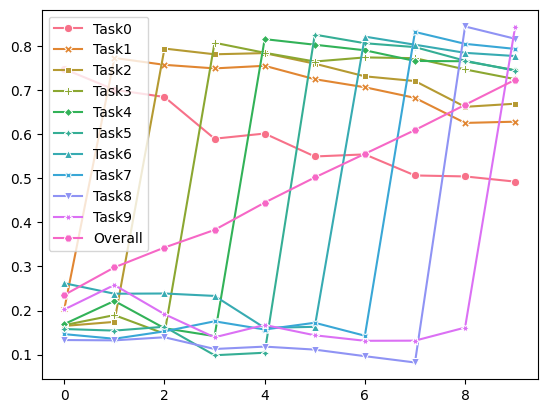

In [13]:
# lineplot every task acc per training
sns.lineplot(data=acc_df, dashes=False, markers=True)

# Qué clase se entrenó en cada tarea / experiencia?

# Store metrics

In [48]:
pickle.dump(accuracies, open(SAVED_METRICS_PATH / "cewc_v1.pkl", "wb"))